# East coast floods


In [1]:
import os
import datetime
import glob

from collections import Counter
import calendar
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy
import cartopy.crs as ccrs
import geopandas as gp
from IPython.display import Image
from scipy.stats import genextreme as gev
import xclim as xc
import cmocean
import seaborn as sns

from unseen import fileio
from unseen import general_utils
from unseen import time_utils
from unseen import indices

In [2]:
# Optional parameters 
# (This cell is tagged "parameters")
dpi = 300

In [3]:
# Parameters
agcd_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_AGCD-CSIRO_r005_1900-2022_annual-aug-to-sep_east-coast-flood-region.zarr.zip"
model_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_HadGEM3-GC31-MM-dcppA-hindcast_196011-201811_annual-aug-to-sep_east-coast-flood-region.zarr.zip"
model_add_bc_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_HadGEM3-GC31-MM-dcppA-hindcast_196011-201811_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-additive.zarr.zip"
model_mulc_bc_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_HadGEM3-GC31-MM-dcppA-hindcast_196011-201811_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip"
similarity_add_bc_file = "/g/data/xv83/dbi599/east-coast-rain/data/similarity-test_Rx15day_HadGEM3-GC31-MM-dcppA-hindcast_197011-201811_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-additive.zarr.zip"
similarity_mulc_bc_file = "/g/data/xv83/dbi599/east-coast-rain/data/similarity-test_Rx15day_HadGEM3-GC31-MM-dcppA-hindcast_197011-201811_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip"
similarity_raw_file = "/g/data/xv83/dbi599/east-coast-rain/data/similarity-test_Rx15day_HadGEM3-GC31-MM-dcppA-hindcast_197011-201811_annual-aug-to-sep_east-coast-flood-region_AGCD-CSIRO.zarr.zip"
independence_plot = "/g/data/xv83/dbi599/east-coast-rain/figures/independence-test_Rx15day_HadGEM3-GC31-MM-dcppA-hindcast_196011-201811_annual-aug-to-sep_east-coast-flood-region.png"
model_name = "HadGEM3-GC31-MM"
min_lead = 0
region_name = "east-coast-flood-region"
shape_file = "/g/data/xv83/dbi599/east-coast-rain/shapefiles/east-coast-flood.shp"
file_list = "/home/599/dbi599/east-coast-rain/file_lists/HadGEM3-GC31-MM_dcppA-hindcast_pr_files.txt"
nino_file = "/g/data/xv83/dbi599/east-coast-rain/data/nino34-anomaly_HadGEM3-GC31-MM-dcppA-hindcast_196011-201811_base-197011-201811.nc"


In [4]:
# Required parameters
assert 'model_name' in locals(), "Must provide a model name"
assert 'region_name' in locals(), "Must provide a region name"
assert 'min_lead' in locals(), "Must provide a minimum lead time"
assert os.path.isfile(file_list), "Must provide the input model files list (papermill option -p file_list [filepath])"
assert os.path.isfile(shape_file), "Must provide the shapefile (papermill option -p shape_file [filepath])"
assert os.path.isfile(agcd_file), "Must provide an AGCD data file (papermill option -p agcd_file [filepath])"
assert os.path.isfile(model_file), "Must provide an model data file (papermill option -p model_file [filepath])"
assert os.path.isfile(model_add_bc_file), "Must provide a model additive bias corrected data file (papermill option -p model_add_bc_file [filepath])"
assert os.path.isfile(model_mulc_bc_file), "Must provide a model multiplicative bias corrected data file (papermill option -p model_mulc_bc_file [filepath])"
assert os.path.isfile(nino_file), "Must provide a model Nino 3.4 data file (papermill option -p nino_file [filepath])"
assert os.path.isfile(similarity_add_bc_file), "Must provide an additive bias corrected similarity test file (papermill option -p similarity_add_bias_file [filepath])"
assert os.path.isfile(similarity_mulc_bc_file), "Must provide an multiplicative bias corrected similarity test file (papermill option -p similarity_mulc_bias_file [filepath])"
assert os.path.isfile(similarity_raw_file), "Must provide an raw data similarity test file (papermill option -p similarity_raw_file [filepath])"
assert os.path.isfile(independence_plot), "Must provide an independence test plot (papermill option -p independence_plot [filepath])"

## Observations

In [5]:
agcd_ds = fileio.open_dataset(agcd_file)
agcd_ds = agcd_ds.dropna('time')

In [6]:
agcd_ds

<xarray.Dataset>
Dimensions:     (time: 122)
Coordinates:
    event_time  (time) <U28 dask.array<chunksize=(122,), meta=np.ndarray>
  * time        (time) object 1901-01-01 09:00:00 ... 2022-01-01 09:00:00
Data variables:
    pr          (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/33)
    CDI:                           Climate Data Interface version ?? (http://...
    CDO:                           Climate Data Operators version 1.7.0 (http...
    Conventions:                   CF-1.6
    acknowledgment:                The Australian Government, Bureau of Meteo...
    analysis_components:           total: the gridded accumulation of rainfall.
    bom-cmp-awap_version:          bom-cmp-awap-1.00-89.0.x86_64
    ...                            ...
    summary:                       The daily and monthly rainfall data repres...
    time_coverage_end:             1900-01-01T09:00:00
    time_coverage_start:           1899-12-31T09:00:00
    title:                         Interpolated Rain Gauge Precipitation
    url:                           http://www.bom.gov.au/climate/
    uuid:                          14333ae2-28fe-4cb6-9f00-677adc94f25e

In [7]:
years = agcd_ds['time'].dt.year.values
agcd_df = pd.DataFrame(index=years)
agcd_df['pr'] = agcd_ds['pr'].values

In [8]:
pr2022 = agcd_ds['pr'].values.max()
print(pr2022)

410.43057


## Model ensemble

### Region selection

In [9]:
with open(file_list) as f:
    all_files = f.read()
    first_file = all_files.split('\n', 1)[0]

In [10]:
first_file

'/g/data/oi10/replicas/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast/s1960-r1i1p1f2/day/pr/gn/v20200417/pr_day_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r1i1p1f2_gn_19601101-19601230.nc'

In [11]:
shapes = gp.read_file(shape_file)

In [12]:
isel_dict = {}
if model_name == 'CAFE':
    isel_dict['ensemble'] = 0
    metadata_file = '/home/599/dbi599/unseen/config/dataset_cafe_daily.yml'
else:
    metadata_file = None

In [13]:
region_ds = fileio.open_dataset(
    first_file,
    metadata_file=metadata_file,
    variables=['pr'],
    lat_bnds=[-40, -20],
    lon_bnds=[140, 160],
    shapefile=shape_file,
    shape_overlap=0.1,
    units={'pr': 'mm day-1'},
    isel=isel_dict,
)

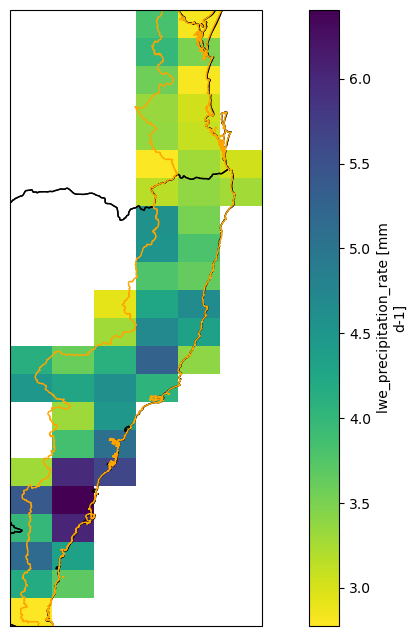

In [14]:
fig = plt.figure(figsize=[12,8])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
region_ds['pr'].mean('time', keep_attrs=True).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='viridis_r',
)
ax.coastlines()
ax.add_feature(cartopy.feature.STATES)
ax.add_geometries(shapes.geometry, ccrs.PlateCarree(), facecolor='none', edgecolor='orange')
plt.show()

### Model data

In [15]:
model_ds = fileio.open_dataset(model_file)
model_add_bc_ds = fileio.open_dataset(model_add_bc_file)
model_mulc_bc_ds = fileio.open_dataset(model_mulc_bc_file)

In [16]:
model_ds

<xarray.Dataset>
Dimensions:     (ensemble: 10, init_date: 59, lead_time: 11)
Coordinates:
  * ensemble    (ensemble) int64 0 1 2 3 4 5 6 7 8 9
    event_time  (init_date, ensemble, lead_time) <U28 dask.array<chunksize=(59, 10, 11), meta=np.ndarray>
  * init_date   (init_date) object 1960-11-01 00:00:00 ... 2018-11-01 00:00:00
  * lead_time   (lead_time) int64 0 1 2 3 4 5 6 7 8 9 10
    time        (lead_time, init_date) object dask.array<chunksize=(11, 59), meta=np.ndarray>
Data variables:
    pr          (init_date, ensemble, lead_time) float64 dask.array<chunksize=(1, 1, 11), meta=np.ndarray>
Attributes: (12/43)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            DCPP
    branch_method:          no parent
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    cmor_version:           3.4.0
    ...                     ...
    table_info:             Creation Date:(13 December 2018) MD5:f0588f7f55b5...
    title:                  HadGEM3-GC31-MM output prepared for CMIP6
    tracking_id:            hdl:21.14100/3163965c-a593-4abd-9b2a-9ee755aef228
    variable_id:            pr
    variable_name:          pr
    variant_label:          r1i1p1f2

### Independence testing

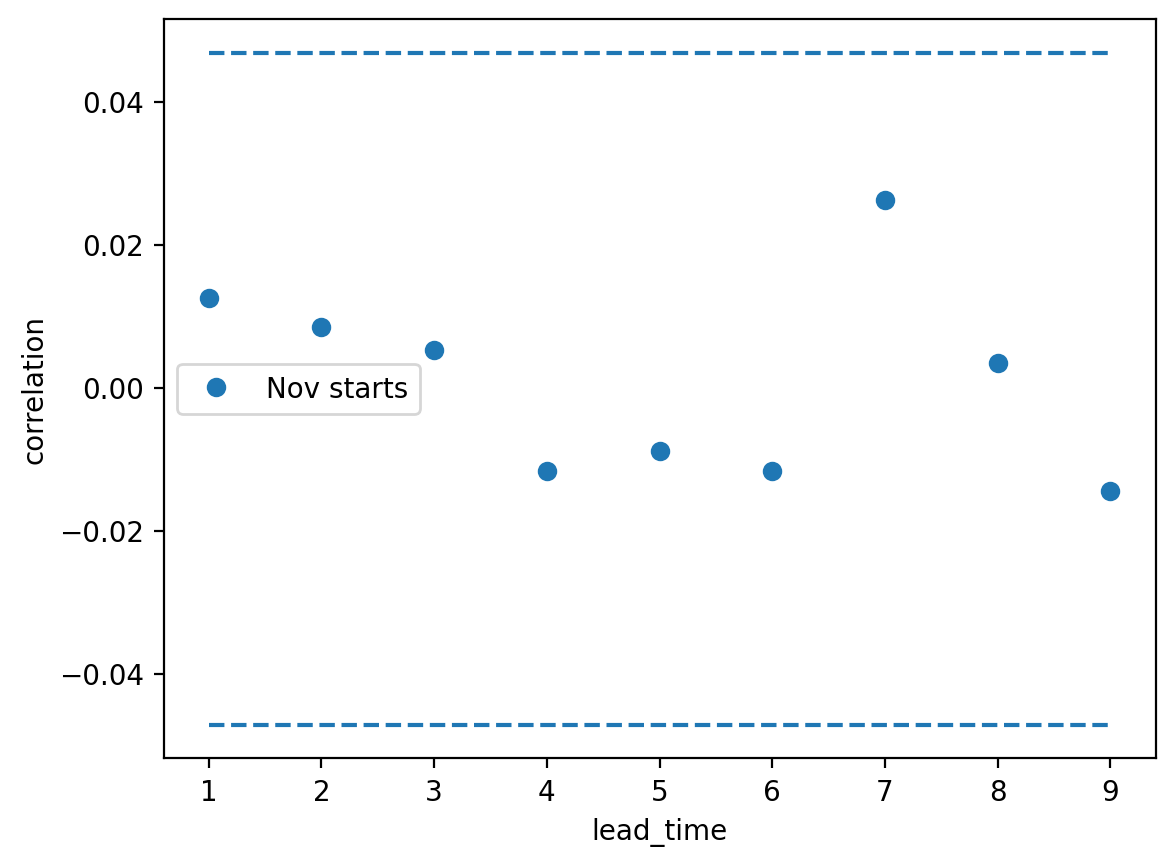

In [17]:
Image(filename=independence_plot)

In [18]:
print(min_lead)

0


In [19]:
model_da = model_ds['pr'].where(model_ds['lead_time'] >= min_lead)

In [20]:
model_da_stacked = model_da.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [21]:
model_da_stacked.shape

(5310,)

In [22]:
model_add_bc_da_stacked = model_add_bc_ds.dropna('lead_time')['pr'].stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [23]:
model_add_bc_da_stacked.shape

(5310,)

In [24]:
model_mulc_bc_da_stacked = model_mulc_bc_ds.dropna('lead_time')['pr'].stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [25]:
model_mulc_bc_da_stacked.shape

(5310,)

### Bias correction and similarity testing

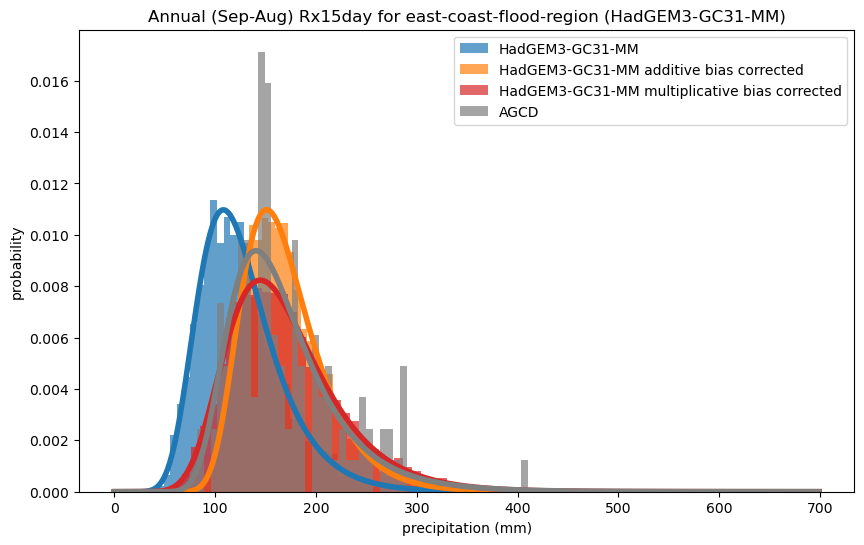

In [26]:
fig = plt.figure(figsize=[10, 6])
gev_xvals = np.arange(0, 700)

model_da.plot.hist(
    bins=50, density=True, label=model_name, alpha=0.7, facecolor='tab:blue',
)
model_gev_shape, model_gev_loc, model_gev_scale = indices.fit_gev(model_da_stacked.values)
model_gev_pdf = gev.pdf(gev_xvals, model_gev_shape, model_gev_loc, model_gev_scale)
plt.plot(gev_xvals, model_gev_pdf, color='tab:blue', linewidth=4.0)

model_add_bc_ds['pr'].plot.hist(
    bins=50, density=True, label=f'{model_name} additive bias corrected', facecolor='tab:orange', alpha=0.7
)
model_add_bc_gev_shape, model_add_bc_gev_loc, model_add_bc_gev_scale = indices.fit_gev(model_add_bc_da_stacked.values)
model_add_bc_gev_pdf = gev.pdf(gev_xvals, model_add_bc_gev_shape, model_add_bc_gev_loc, model_add_bc_gev_scale)
plt.plot(gev_xvals, model_add_bc_gev_pdf, color='tab:orange', linewidth=4.0)

model_mulc_bc_ds['pr'].plot.hist(
    bins=50, density=True, label=f'{model_name} multiplicative bias corrected', facecolor='tab:red', alpha=0.7
)
model_mulc_bc_gev_shape, model_mulc_bc_gev_loc, model_mulc_bc_gev_scale = indices.fit_gev(model_mulc_bc_da_stacked.values)
model_mulc_bc_gev_pdf = gev.pdf(gev_xvals, model_mulc_bc_gev_shape, model_mulc_bc_gev_loc, model_mulc_bc_gev_scale)
plt.plot(gev_xvals, model_mulc_bc_gev_pdf, color='tab:red', linewidth=4.0)

agcd_ds['pr'].plot.hist(
    bins=50, density=True, label='AGCD', facecolor='tab:gray', alpha=0.7
)
agcd_gev_shape, agcd_gev_loc, agcd_gev_scale = indices.fit_gev(agcd_ds['pr'].values)
agcd_gev_pdf = gev.pdf(gev_xvals, agcd_gev_shape, agcd_gev_loc, agcd_gev_scale)
plt.plot(gev_xvals, agcd_gev_pdf, color='tab:gray', linewidth=4.0)

plt.xlabel('precipitation (mm)')
plt.ylabel('probability')
plt.title(f'Annual (Sep-Aug) Rx15day for {region_name} ({model_name})')
plt.legend()
#plt.savefig(f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_histogram_{model_name}_{region_name}.png',
#            bbox_inches='tight', facecolor='white', dpi=dpi)
plt.show()

In [27]:
print(f'raw data shape parameter: {model_gev_shape:.3f}')
print(f'raw data location parameter: {model_gev_loc:.3f}') 
print(f'raw data scale parameter: {model_gev_scale:.3f}')

raw data shape parameter: 0.005
raw data location parameter: 108.016
raw data scale parameter: 33.526


In [28]:
print(f'additive corrected shape parameter: {model_add_bc_gev_shape:.3f}')
print(f'additive corrected location parameter: {model_add_bc_gev_loc:.3f}') 
print(f'additive corrected scale parameter: {model_add_bc_gev_scale:.3f}')

additive corrected shape parameter: 0.008
additive corrected location parameter: 150.741
additive corrected scale parameter: 33.516


In [29]:
print(f'multiplicative corrected shape parameter: {model_mulc_bc_gev_shape:.3f}')
print(f'multiplicative corrected location parameter: {model_mulc_bc_gev_loc:.3f}') 
print(f'multiplicative corrected scale parameter: {model_mulc_bc_gev_scale:.3f}')

multiplicative corrected shape parameter: 0.007
multiplicative corrected location parameter: 144.418
multiplicative corrected scale parameter: 44.673


We can look at p-values for the KS-test and Anderson-Darling test for each lead time.

p > 0.05 means the null hypothesis (that the two samples are from the same population) can't be rejected.

In [27]:
similarity_raw_ds = fileio.open_dataset(similarity_raw_file)

In [28]:
similarity_raw_ds['ks_pval'].values

array([3.8604120e-10, 1.4197805e-09, 2.8738205e-07, 1.6528110e-08,
       1.2601515e-07, 1.0778587e-06, 1.5363096e-06, 1.1911399e-06,
       6.9467183e-06], dtype=float32)

In [29]:
similarity_raw_ds['ad_pval'].values

array([0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001],
      dtype=float32)

In [30]:
similarity_add_bias_ds = fileio.open_dataset(similarity_add_bc_file)

In [31]:
similarity_add_bias_ds['ks_pval'].values

array([0.34203297, 0.38722515, 0.6667663 , 0.2074122 , 0.48781037,
       0.61827475, 0.3139235 , 0.50574476, 0.40307745], dtype=float32)

In [32]:
similarity_add_bias_ds['ad_pval'].values

array([0.16533643, 0.25      , 0.25      , 0.20388898, 0.25      ,
       0.25      , 0.25      , 0.25      , 0.25      ], dtype=float32)

In [33]:
similarity_mulc_bias_ds = fileio.open_dataset(similarity_mulc_bc_file)

In [34]:
similarity_mulc_bias_ds['ks_pval'].values

array([0.85785085, 0.28910512, 0.4214731 , 0.67612356, 0.6209008 ,
       0.7360097 , 0.5826059 , 0.52642095, 0.7730237 ], dtype=float32)

In [35]:
similarity_mulc_bias_ds['ad_pval'].values

array([0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25],
      dtype=float32)

### Exceedance curves

In [36]:
def plot_exceedance(sample_ds, model_name, outfile=None):
    """Plot single exceedance curve"""
    
    sorted_data, exceedance_data = general_utils.exceedance_curve(sample_ds)
    
    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot()
    ax.plot(sorted_data, exceedance_data)
    ax.set_title(f'Annual (Sep-Aug) Rx15day for {region_name} ({model_name})')
    ax.set_ylabel('likelihood of exceedance (%)')
    ax.set_xlabel('Rx15day precipitation (mm)')
    ax.axvline(pr2022, color='0.5', linestyle='--')
    if outfile:
        plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
        print(outfile)
    else:
        plt.show()

In [37]:
def gev_event_likelihood(event, shape, loc, scale):
    """Get likelihood stats for an event from a GEV fit"""

    probability = gev.sf(event, shape, loc=loc, scale=scale)
    return_period = 1. / probability
    percentile = (1 - probability) * 100
    print(f'{percentile:.2f}% percentile')
    print(f'{return_period:.0f} year return period\n')

In [38]:
def plot_exceedance_by_decade(sample_ds, model_name):
    """Plot exceedance curve by decade"""

    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot()
    if model_name == 'CAFE':
        start_years = [1995, 2000, 2005, 2010, 2015]
        step = 4
    else:
        start_years = [1960, 1970, 1980, 1990, 2000, 2010]
        step = 9
    colors = iter(plt.cm.hot_r(np.linspace(0.3, 1, len(start_years))))

    for start_year in start_years:
        end_year = start_year + step
        start_date = f'{start_year}-01-01'
        end_date = f'{end_year}-12-25'
        ds_selection = time_utils.select_time_period(sample_ds, [start_date, end_date])
        ds_selection = ds_selection.dropna('sample')
        sorted_data, exceedance_data = general_utils.exceedance_curve(ds_selection)
        n_years = len(sorted_data)
        label = f'{start_year}-{end_year} ({n_years} samples)'
        color = next(colors)
        ax.plot(sorted_data, exceedance_data, label=label, color=color)
    
        print(f'{start_year}-{end_year}')
        n_events, n_population, return_period, percentile = general_utils.event_in_context(ds_selection.values, pr2022, 'above')
        print(f'{n_events} events in {n_population} samples')
        print(f'{percentile:.2f}% percentile')
        print(f'{return_period:.0f} year return period')
        print('GEV:')
        gev_shape, gev_loc, gev_scale = indices.fit_gev(ds_selection.values)
        gev_event_likelihood(pr2022, gev_shape, gev_loc, gev_scale)

    ax.set_title(f'Annual (Sep-Aug) Rx15day for {region_name} ({model_name})')
    ax.set_ylabel('likelihood of exceedance (%)')
    ax.set_xlabel('Rx15day precipitation (mm)')
    ax.legend()
    ax.axvline(pr2022, color='0.5', linestyle='--')
#    outfile = f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_precip_exceedence_{region_name}_{model_name}_by-decade.png'
#    plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
    plt.show()
#    print(outfile)

#### Additive bias corrected data

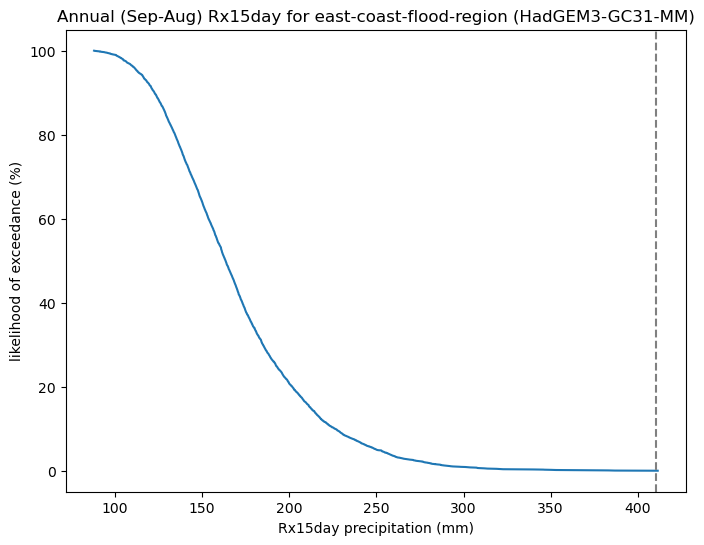

In [39]:
#outfile = f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_precip_exceedence_{region_name}_{model_name}.png'
plot_exceedance(model_add_bc_da_stacked, model_name)#, outfile=outfile)

In [40]:
n_events_add_bc, n_population_add_bc, return_period_add_bc, percentile_add_bc = general_utils.event_in_context(model_add_bc_da_stacked.values, pr2022, 'above')
print('ADDITIVE BIAS CORRECTED DATA')
print(f'{n_events_add_bc} events in {n_population_add_bc} samples')
print(f'{percentile_add_bc:.2f}% percentile')
print(f'{return_period_add_bc:.0f} year return period')

ADDITIVE BIAS CORRECTED DATA
1 events in 5310 samples
99.98% percentile
5310 year return period


In [41]:
print('ADDITIVE BIAS CORRECTED GEV')
gev_event_likelihood(pr2022, model_add_bc_gev_shape, model_add_bc_gev_loc, model_add_bc_gev_scale)

ADDITIVE BIAS CORRECTED GEV
99.97% percentile
2995 year return period



#### Multiplicative bias corrected data

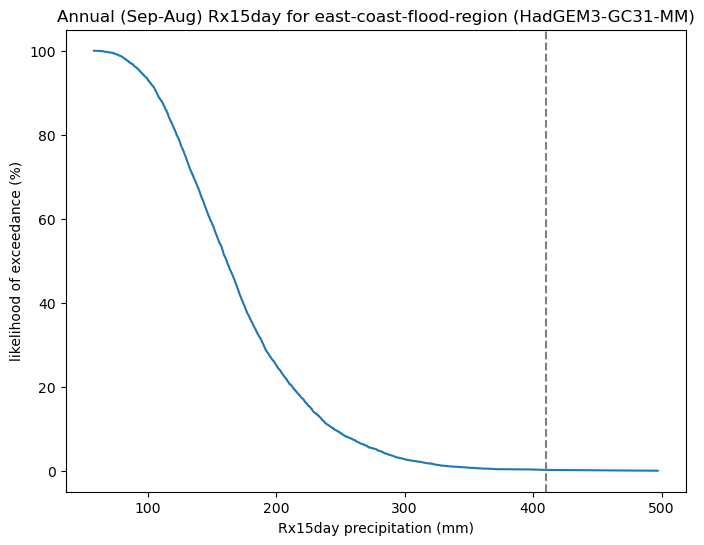

In [42]:
plot_exceedance(model_mulc_bc_da_stacked, model_name)

In [43]:
n_events_mulc_bc, n_population_mulc_bc, return_period_mulc_bc, percentile_mulc_bc = general_utils.event_in_context(model_add_bc_da_stacked.values, pr2022, 'above')
print('MULTIPLICATIVE BIAS CORRECTED DATA')
print(f'{n_events_mulc_bc} events in {n_population_mulc_bc} samples')
print(f'{percentile_mulc_bc:.2f}% percentile')
print(f'{return_period_mulc_bc:.0f} year return period')

MULTIPLICATIVE BIAS CORRECTED DATA
1 events in 5310 samples
99.98% percentile
5310 year return period


In [44]:
print('MULTIPLICATIVE BIAS CORRECTED GEV')
gev_event_likelihood(pr2022, model_mulc_bc_gev_shape, model_mulc_bc_gev_loc, model_mulc_bc_gev_scale)

MULTIPLICATIVE BIAS CORRECTED GEV
99.77% percentile
441 year return period



1960-1969


/home/599/dbi599/unseen/unseen/general_utils.py:163: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


0 events in 450 samples
100.00% percentile
inf year return period
GEV:
99.81% percentile
525 year return period

1970-1979
1 events in 900 samples
99.89% percentile
900 year return period
GEV:
99.95% percentile
1828 year return period

1980-1989
2 events in 900 samples
99.78% percentile
450 year return period
GEV:
99.67% percentile
306 year return period

1990-1999
1 events in 900 samples
99.89% percentile
900 year return period
GEV:
99.67% percentile
304 year return period

2000-2009
3 events in 900 samples
99.67% percentile
300 year return period
GEV:
99.75% percentile
395 year return period

2010-2019
3 events in 900 samples
99.67% percentile
300 year return period
GEV:
99.91% percentile
1166 year return period



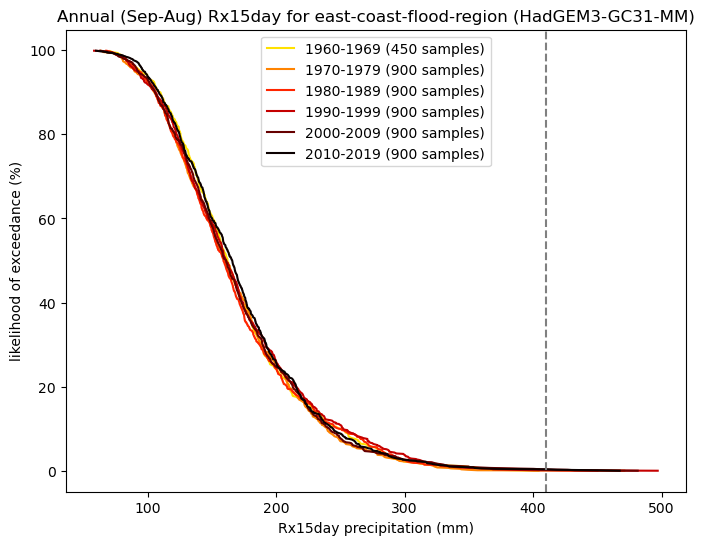

In [45]:
plot_exceedance_by_decade(model_mulc_bc_da_stacked, model_name)

#### Raw data

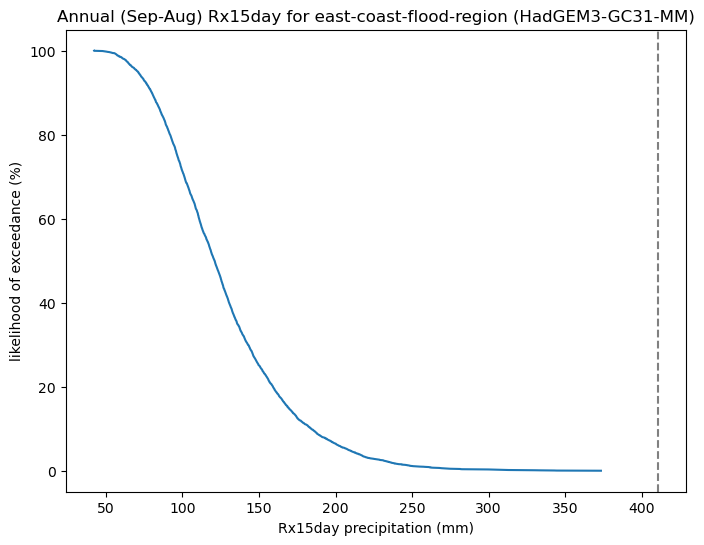

In [46]:
plot_exceedance(model_da_stacked, model_name)

In [47]:
n_events, n_population, return_period, percentile = general_utils.event_in_context(model_da_stacked.values, pr2022, 'above')
print('RAW DATA')
print(f'{n_events} events in {n_population} samples')
print(f'{percentile:.2f}% percentile')
print(f'{return_period:.0f} year return period')

RAW DATA
0 events in 5310 samples
100.00% percentile
inf year return period


/home/599/dbi599/unseen/unseen/general_utils.py:163: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


In [48]:
print('RAW GEV')
gev_event_likelihood(pr2022, model_gev_shape, model_gev_loc, model_gev_scale)

RAW GEV
99.99% percentile
10020 year return period



### Seasonality

In [49]:
model_df = model_da_stacked.to_dataframe()
model_df = model_df.dropna()

In [50]:
event_months = [int(date[5:7]) for date in model_df['event_time'].values]
event_years = [int(date[0:4]) for date in model_df['event_time'].values]

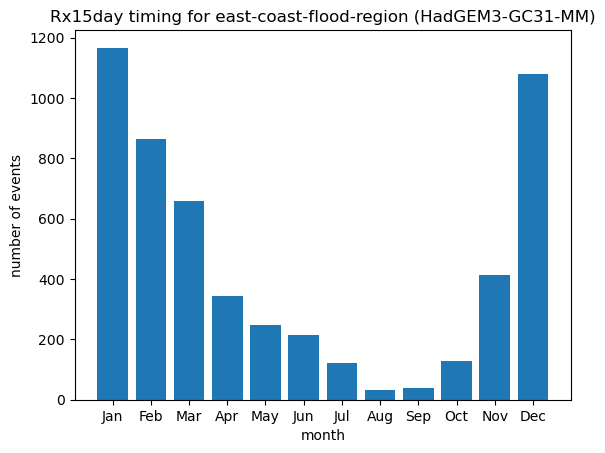

In [51]:
month_counts = Counter(event_months)
months = np.arange(1, 13)
counts = [month_counts[month] for month in months]

plt.bar(months, counts)
plt.title(f'Rx15day timing for {region_name} ({model_name})')
plt.ylabel('number of events')
plt.xlabel('month')
xlabels = [calendar.month_abbr[i] for i in months]
plt.xticks(months, xlabels)
#plt.savefig(
#    f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_timing_AGCD_{region_name}.png',
#    bbox_inches='tight',
#    facecolor='white',
#    dpi=dpi
#)
plt.show()

### Relationship with ENSO

In [52]:
nino_ds = fileio.open_dataset(nino_file)
nino_ds = nino_ds.assign_coords({'init_date': [date.strftime('%Y%m') for date in nino_ds['init_date'].values]})
nino_ds

<xarray.Dataset>
Dimensions:    (init_date: 59, ensemble: 10, lead_time: 125)
Coordinates:
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 7 ... 118 119 120 121 122 123 124
  * ensemble   (ensemble) int64 0 1 2 3 4 5 6 7 8 9
  * init_date  (init_date) <U6 '196011' '196111' '196211' ... '201711' '201811'
    time       (lead_time, init_date) object dask.array<chunksize=(125, 59), meta=np.ndarray>
Data variables:
    tos        (init_date, ensemble, lead_time) float32 dask.array<chunksize=(59, 10, 125), meta=np.ndarray>
Attributes:
    history:  Fri Feb 03 17:56:10 2023: /g/data/xv83/dbi599/miniconda3/envs/u...

In [53]:
nino_values = []
for index, row in model_df.iterrows():
    event_init_date = row['init_date'].strftime('%Y%m')
    event_ensemble = row['ensemble']
    event_year_month = row['time'].strftime('%Y-%m')
    nino_selection = nino_ds.sel({'init_date': event_init_date, 'ensemble': event_ensemble})
    nino_selection = nino_selection.swap_dims({'lead_time': 'time'})
    nino_year_month = [date.strftime('%Y-%m') for date in nino_selection['time'].values]
    nino_selection = nino_selection.assign_coords({'time': nino_year_month})
    nino_value = float(nino_selection['tos'].sel({'time': event_year_month}).values)
    nino_values.append(nino_value)

In [54]:
model_df['nino34'] = nino_values

/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


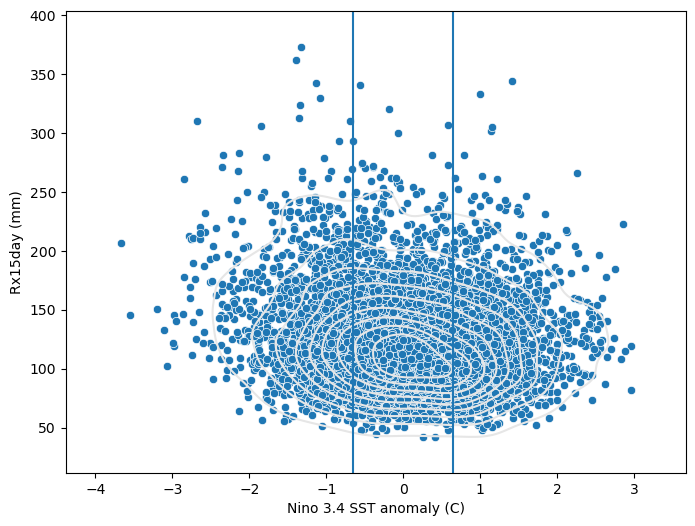

In [55]:
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(111)

sns.scatterplot(ax=ax, data=model_df, x='nino34', y='pr')
sns.kdeplot(ax=ax, data=model_df, x='nino34', y='pr', color='0.9', linewidth=1)

ax.set_ylabel('Rx15day (mm)')
ax.set_xlabel('Nino 3.4 SST anomaly (C)')
ax.axvline(0.65)
ax.axvline(-0.65)
plt.show()

### Meteorology

In [56]:
def plot_average(start_date, end_date, color_da=None, color_var=None, contour_da=None, contour_var=None):
    """Plot average"""
    
    fig = plt.figure(figsize=[10, 5])
    map_proj=ccrs.PlateCarree(central_longitude=180)
    ax1 = fig.add_subplot(1, 1, 1, projection=map_proj)       
    
    if color_var:
        if color_var == 'pr':
            levels = [0, 100, 200, 300, 400, 500, 600, 700, 800]
            label = 'total precipitation (mm)'
            cmap = cmocean.cm.rain
            extend = 'max'
        elif color_var == 'ua300':
            levels = [-30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30]
            label = '300hPa zonal wind'
            cmap='RdBu_r'
            extend = 'both'
        else:
            raise ValueError('Invalid color variable')
        color_da.plot(
            ax=ax1,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            levels=levels,
            extend=extend,
            cbar_kwargs={'label': label},
        )
    
    if contour_var:
        if contour_var == 'z500':
            levels = np.arange(5000, 6300, 50)
        elif contour_var == 'psl':
            levels = np.arange(900, 1100, 2.5)
        elif contour_var == 'ua300':
            levels = np.arange(15, 60, 5)
        else:
            raise ValueError('Invalid contour variable')
        lines = contour_da.plot.contour(
            ax=ax1,
            transform=ccrs.PlateCarree(),
            levels=levels,
            colors=['0.1']
        )
        ax1.clabel(lines, colors=['0.1'], manual=False, inline=True)
    
    ax1.coastlines()
    ax1.set_extent([90, 205, -55, 10], crs=ccrs.PlateCarree())
    ax1.gridlines(linestyle='--', draw_labels=True)
    if contour_var:
        ax1.set_title(f'Average {contour_var} ({contour_da.units}), {start_date} to {end_date}')
    else:
        ax1.set_title(f'{start_date} to {end_date}')
#    plt.savefig(
#        f'/home/599/dbi599/east-coast-rain/{color_var}-{contour_var}_mean_BARRA2_{start_date}_{end_date}.png',
#        bbox_inches='tight',
#        facecolor='white',
#        dpi=300
#    )
    plt.show()

In [57]:
ranked_events = model_df.sort_values(by=['pr'], ascending=False)
ranked_events.head(n=10)

event_time                 time  \
ensemble init_date           lead_time                                    
0        1999-11-01 00:00:00 9          2009-02-18  2008-11-01 12:00:00   
1        1994-11-01 00:00:00 2          1996-12-30  1996-11-01 12:00:00   
0        1982-11-01 00:00:00 7          1990-01-11  1989-11-01 12:00:00   
         2010-11-01 00:00:00 3          2014-01-24  2013-11-01 12:00:00   
8        2009-11-01 00:00:00 2          2012-01-26  2011-11-01 12:00:00   
9        1971-11-01 00:00:00 1          1973-02-26  1972-11-01 12:00:00   
         2000-11-01 00:00:00 3          2004-03-04  2003-11-01 12:00:00   
7        1979-11-01 00:00:00 8          1988-02-09  1987-11-01 12:00:00   
6        2005-11-01 00:00:00 8          2014-02-20  2013-11-01 12:00:00   
9        2010-11-01 00:00:00 3          2014-03-20  2013-11-01 12:00:00   

                                        ensemble            init_date  \
ensemble init_date           lead_time                                  
0        1999-11-01 00:00:00 9                 0  1999-11-01 00:00:00   
1        1994-11-01 00:00:00 2                 1  1994-11-01 00:00:00   
0        1982-11-01 00:00:00 7                 0  1982-11-01 00:00:00   
         2010-11-01 00:00:00 3                 0  2010-11-01 00:00:00   
8        2009-11-01 00:00:00 2                 8  2009-11-01 00:00:00   
9        1971-11-01 00:00:00 1                 9  1971-11-01 00:00:00   
         2000-11-01 00:00:00 3                 9  2000-11-01 00:00:00   
7        1979-11-01 00:00:00 8                 7  1979-11-01 00:00:00   
6        2005-11-01 00:00:00 8                 6  2005-11-01 00:00:00   
9        2010-11-01 00:00:00 3                 9  2010-11-01 00:00:00   

                                        lead_time          pr    nino34  
ensemble init_date           lead_time                                   
0        1999-11-01 00:00:00 9                  9  373.336472 -1.327885  
1        1994-11-01 00:00:00 2                  2  362.385748 -1.391947  
0        1982-11-01 00:00:00 7                  7  344.284586  1.418348  
         2010-11-01 00:00:00 3                  3  342.899792 -1.135759  
8        2009-11-01 00:00:00 2                  2  340.771740 -0.560656  
9        1971-11-01 00:00:00 1                  1  333.123206  1.003038  
         2000-11-01 00:00:00 3                  3  330.034569 -1.082582  
7        1979-11-01 00:00:00 8                  8  323.852402 -1.345613  
6        2005-11-01 00:00:00 8                  8  320.887465 -0.179911  
9        2010-11-01 00:00:00 3                  3  312.903275 -1.357731

In [58]:
model_add_bc_df = model_add_bc_ds['pr'].to_dataframe()
model_add_bc_df = model_add_bc_df.dropna()
model_add_bc_df = model_add_bc_df.reset_index()
ranked_add_bc_events = model_add_bc_df.sort_values(by=['pr'], ascending=False)
ranked_add_bc_events.head(n=10)

,init_date,ensemble,lead_time,event_time,time,pr
3518,1999-11-01 00:00:00,0,9,2009-02-18,2008-11-01 12:00:00,411.409935
3070,1994-11-01 00:00:00,1,2,1996-12-30,1996-11-01 12:00:00,408.324046
4483,2009-11-01 00:00:00,8,2,2012-01-26,2011-11-01 12:00:00,386.710038
1986,1982-11-01 00:00:00,0,7,1990-01-11,1989-11-01 12:00:00,384.158968
4502,2010-11-01 00:00:00,0,3,2014-01-24,2013-11-01 12:00:00,383.082018
1071,1971-11-01 00:00:00,9,1,1973-02-26,1972-11-01 12:00:00,382.765827
3683,2000-11-01 00:00:00,9,3,2004-03-04,2003-11-01 12:00:00,370.216796
1780,1979-11-01 00:00:00,7,8,1988-02-09,1987-11-01 12:00:00,363.448154
4111,2005-11-01 00:00:00,6,8,2014-02-20,2013-11-01 12:00:00,360.483217
4583,2010-11-01 00:00:00,9,3,2014-03-20,2013-11-01 12:00:00,353.085502


In [59]:
model_mulc_bc_df = model_mulc_bc_ds['pr'].to_dataframe()
model_mulc_bc_df = model_mulc_bc_df.dropna()
model_mulc_bc_df = model_mulc_bc_df.reset_index()
ranked_mulc_bc_events = model_mulc_bc_df.sort_values(by=['pr'], ascending=False)
ranked_mulc_bc_events.head(n=10)

,init_date,ensemble,lead_time,event_time,time,pr
3070,1994-11-01 00:00:00,1,2,1996-12-30,1996-11-01 12:00:00,497.019885
3518,1999-11-01 00:00:00,0,9,2009-02-18,2008-11-01 12:00:00,481.417948
1071,1971-11-01 00:00:00,9,1,1973-02-26,1972-11-01 12:00:00,470.995945
4483,2009-11-01 00:00:00,8,2,2012-01-26,2011-11-01 12:00:00,467.375806
1986,1982-11-01 00:00:00,0,7,1990-01-11,1989-11-01 12:00:00,450.119319
4502,2010-11-01 00:00:00,0,3,2014-01-24,2013-11-01 12:00:00,449.375301
3683,2000-11-01 00:00:00,9,3,2004-03-04,2003-11-01 12:00:00,432.515235
3969,2004-11-01 00:00:00,1,1,2006-03-28,2005-11-01 12:00:00,426.705989
1780,1979-11-01 00:00:00,7,8,1988-02-09,1987-11-01 12:00:00,422.498638
4111,2005-11-01 00:00:00,6,8,2014-02-20,2013-11-01 12:00:00,418.630574


1999 (2009-02-18), ensemble: r1, 373.3364721823764mm


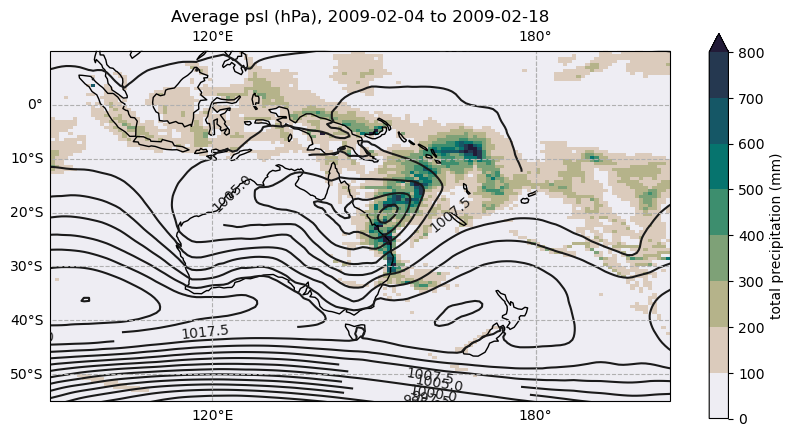

1994 (1996-12-30), ensemble: r2, 362.3857479784449mm


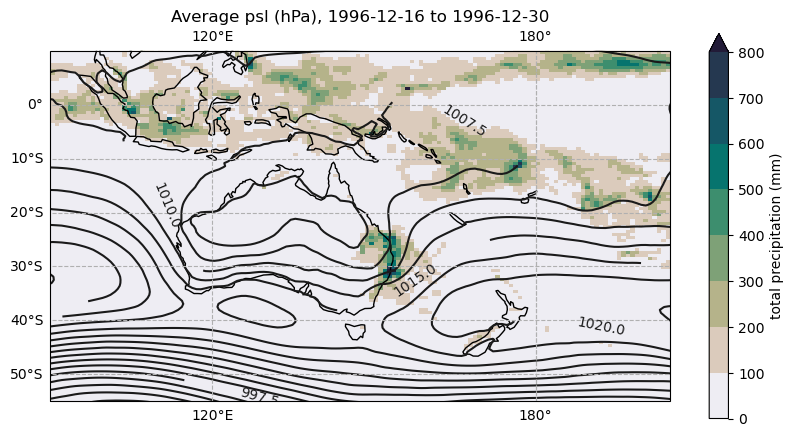

1982 (1990-01-11), ensemble: r1, 344.2845864796246mm


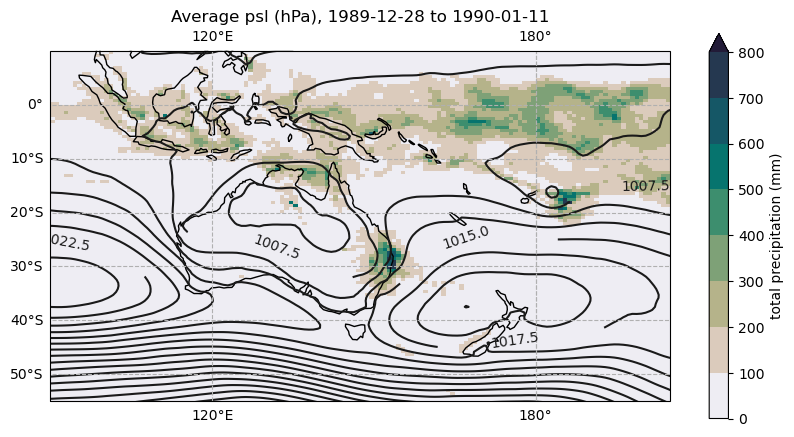

2010 (2014-01-24), ensemble: r1, 342.89979161783907mm


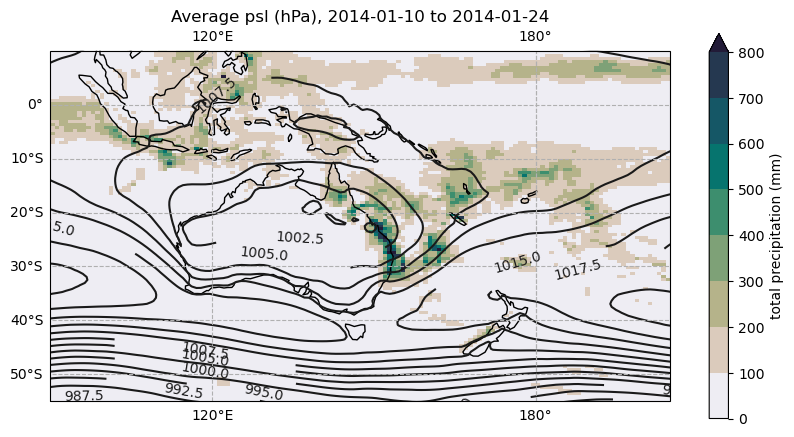

In [60]:
for index, row in ranked_events.head(n=4).iterrows():
    init_date = int(row['init_date'].strftime('%Y'))
    ensemble = int(row['ensemble']) + 1
    end_date = row['event_time']
    rx_value = row['pr']
    print(f'{init_date} ({end_date}), ensemble: r{ensemble}, {rx_value}mm')
    
    start_datetime = datetime.datetime.strptime(end_date, "%Y-%m-%d") - datetime.timedelta(days=14)
    start_date = start_datetime.strftime("%Y-%m-%d")
    
    pr_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-r{ensemble}i1p1f2/day/pr/*/*/*.nc')
    pr_files.sort()
    ds_pr = fileio.open_dataset(pr_files, variables=['pr'],)
    
    psl_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-r{ensemble}i1p1f2/day/psl/*/*/*.nc')
    psl_files.sort()
    ds_psl = fileio.open_dataset(psl_files, variables=['psl'],)
    
#    zg_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-r{ensemble}i1p1f1/day/zg/*/*/*.nc')
#    zg_files.sort()
#    ds_zg = fileio.open_dataset(zg_files, variables=['zg'],)
    
#    ua_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-r{ensemble}i1p1f1/day/ua/*/*/*.nc')
#    ua_files.sort()
#    ds_ua = fileio.open_dataset(ua_files, variables=['ua'],)

    pr_da = ds_pr.sel({'time': slice(start_date, end_date)})['pr']
    pr_da = xc.units.convert_units_to(pr_da, 'mm d-1')
    psl_da = ds_psl.sel({'time': slice(start_date, end_date)})['psl']
    psl_da = xc.units.convert_units_to(psl_da, 'hPa')
#    zg_da = ds_zg.sel({'time': slice(start_date, end_date)})['zg']
#    z500_da = zg_da.sel({'plev': 50000}, method='nearest')
#    ua_da = ds_ua.sel({'time': slice(start_date, end_date)})['ua']
#    ua300_da = ua_da.sel({'plev': 30000}, method='nearest')

    pr_da_sum = pr_da.sum('time', keep_attrs=True)
    psl_da_mean = psl_da.mean('time', keep_attrs=True)
#    z500_da_mean = z500_da.mean('time', keep_attrs=True)
#    ua300_da_mean = ua300_da.mean('time', keep_attrs=True) 

    plot_average(start_date, end_date, pr_da_sum, 'pr', psl_da_mean, 'psl')
#    plot_average(start_date, end_date, pr_da_sum, 'pr', z500_da_mean, 'z500')
#    plot_average(start_date, end_date, ua300_da_mean, 'ua300', z500_da_mean, 'z500')